<h1> B: 2. Implement 2D Convolution using vectorisation</h1>

<h4> In part A we used circulant  a matrix to calculate g = Hf. Similarly, for 2D convolution we will use Doubly Block Toeplitz/ Circulent matrices- following the procedure from the previously cited source. </h4>

<h4> The goal is to extend my approach in A to solve for g = Xb. 
<br>
Where X is of size (n + m -1) * (n + m-1), and X consists of n circulant matrices corresponding to the n rows of the filter. </h4>

Initial Naive attempt. Using the same primitives from A

In [19]:
import numpy as np
from scipy import signal, datasets
from scipy import fft, ndimage
from PIL import Image
import matplotlib.pyplot as plt
import time

#function from part A
def createToeplitzMatrix(filter, input_len):
    filter = filter[::-1]  
    filter_len = len(filter)
    output_len = input_len + filter_len - 1  
    matrix = np.zeros((output_len, input_len))  

    matrix[:filter_len, 0] = filter
    
    for i in range(1, input_len):
        matrix[i:i+filter_len, i] = filter
    
    return matrix

In [20]:
def matrix_to_vector(input):
    input_h, input_w = input.shape
    output_vector = np.zeros(input_h * input_w, dtype=input.dtype) #output size for each matrix
    
    #flip the input matrix upside down because the last row should go first
    input = np.flipud(input)
    
    #flatten the matrix row by row into a vector
    for i, row in enumerate(input):
        st = i * input_w
        nd = st + input_w
        output_vector[st:nd] = row
    
    return output_vector

def vector_to_matrix(input, output_shape):
    output_h, output_w = output_shape
    output = np.zeros(output_shape, dtype=input.dtype)
    
    #reshape the vector into a matrix row by row
    for i in range(output_h):
        st = i * output_w
        nd = st + output_w
        output[i, :] = input[st:nd]
    
    #flip the output matrix upside down once again to get the correct result
    output = np.flipud(output)
    
    return output

In [21]:
def naive_convolution_as_multiplication(I, F):
    I_row_num, I_col_num = I.shape
    F_row_num, F_col_num = F.shape
    
    output_row_num = I_row_num + F_row_num - 1
    output_col_num = I_col_num + F_col_num - 1
    
    print('Output dimension:', output_row_num, output_col_num)
    
    #zero-pad the filter to match the size needed for convolution
    F_zero_padded = np.pad(F, ((output_row_num - F_row_num, 0),
                               (0, output_col_num - F_col_num)),
                            'constant', constant_values=0)
    
    print('F_zero_padded:\n', F_zero_padded)
    
    #create Toeplitz matrices for each row of the zero-padded filter
    toeplitz_list = []
    for i in range(F_zero_padded.shape[0] - 1, -1, -1):  #iterate from last row to the first row
        row = F_zero_padded[i, :]  #i-th row of the filter
        toeplitz_m = createToeplitzMatrix(row, I_col_num)  #manually create the Toeplitz matrix (I will change this in the next approach)
        toeplitz_list.append(toeplitz_m)
    
        print(f'Toeplitz matrix for row {i}:\n', toeplitz_m)
    
    #generate indices for the doubly block circulant matrix
    c = range(1, F_zero_padded.shape[0] + 1) #the idea is that every row of the filter will have a different index
    r = np.r_[c[0], np.zeros(I_row_num - 1, dtype=int)]
    doubly_indices = createToeplitzMatrix(c, I_row_num)  #reuse the Toeplitz creation function from part A
    

    #create an empty doubly block circulant matrix
    toeplitz_shape = toeplitz_list[0].shape
    h = toeplitz_shape[0] * doubly_indices.shape[0]
    w = toeplitz_shape[1] * doubly_indices.shape[1]
    doubly_blocked = np.zeros((h, w))
    
    #fill the doubly block circulant matrix with the  Toeplitz matrices
    for i in range(doubly_indices.shape[0]):
        for j in range(doubly_indices.shape[1]):
            start_i = i * toeplitz_shape[0]
            start_j = j * toeplitz_shape[1]
            end_i = start_i + toeplitz_shape[0]
            end_j = start_j + toeplitz_shape[1]
            doubly_blocked[start_i:end_i, start_j:end_j] = toeplitz_list[int(doubly_indices[i, j])-1]
    
    
    print('Doubly block circulant matrix:\n', doubly_blocked)
    
    # Convert the input matrix to a vector
    vectorized_I = matrix_to_vector(I)
    
    print('Vectorized input:\n', vectorized_I)
    
    # Perform the convolution by matrix multiplication
    result_vector = np.matmul(doubly_blocked, vectorized_I)
    
    print('Resulting vector after multiplication:\n', result_vector)
    
    # Reshape the result vector back to a matrix form
    output = vector_to_matrix(result_vector, (output_row_num, output_col_num))
    
    print('Final output after reshaping:\n', output)
      
    return output

In [22]:
#example 
I = np.array([[1, 2, 7], [3, 4, 9], [1, 8, 4]])
F = np.array([[1, 0], [0, -1]])
output = naive_convolution_as_multiplication(I, F)

Output dimension: 4 4
F_zero_padded:
 [[ 0  0  0  0]
 [ 0  0  0  0]
 [ 1  0  0  0]
 [ 0 -1  0  0]]
Toeplitz matrix for row 3:
 [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [-1.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  0. -1.]
 [ 0.  0.  0.]]
Toeplitz matrix for row 2:
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Toeplitz matrix for row 1:
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Toeplitz matrix for row 0:
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Doubly block circulant matrix:
 [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 

<h3> Just by looking at the values in the intermediate matrices, the results are off</h3>

In [23]:
print("My Convolution Output:\n", output)

print("Scipy Output:\n", signal.convolve2d(I, F, mode='full'))

My Convolution Output:
 [[0. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Scipy Output:
 [[ 1  2  7  0]
 [ 3  3  7 -7]
 [ 1  5  0 -9]
 [ 0 -1 -8 -4]]


The output does not match at all either

<h4>The discrepency between the actual convolution and my implementation is because of the poor manual implementation of toeplitz function which I took from part A (meant for 1D convolution). </h4>

<h5>For this new approach, I will first define a different implementation of toeplitz (trying to recreate scipy.linalg.toeplitz) </h5>

In [24]:
def man_toeplitz(c, r=None): #c is the first column of the Toeplitz matrix, r is the first row of the Toeplitz matrix
    #convert c to a 1-D array
    c = np.asarray(c).flatten()
    if r is None:
        #if r is not given, use the conjugate of c
        r = np.conjugate(c)
    else:
        #convert r to a 1-D array
        r = np.asarray(r).flatten()   
    #first element of r is ignored
    r = r[1:]
    #frame of the Toeplitz matrix
    A = np.zeros((len(c), len(r) + 1), dtype=np.result_type(c[0], r[0]))
    #fill the first column
    A[:, 0] = c
    #fill the first row
    A[0, 1:] = r
    #rest of the matrix follows
    for i in range(1, len(c)):
        A[i, 1:] = A[i-1, :-1]
    
    return A

#example
print(man_toeplitz([1, 2, 3], [1, 4, 5, 6]))



[[1 4 5 6]
 [2 1 4 5]
 [3 2 1 4]]


<h3> Fixed implementation </h3>

In [25]:
#similar function with slight modifications
def new_conv_mul(I, F): 
    I_row_num, I_col_num = I.shape 
    F_row_num, F_col_num = F.shape
    #calculate output dimensions
    output_row_num = I_row_num + F_row_num - 1
    output_col_num = I_col_num + F_col_num - 1
    print('output dimension:', output_row_num, output_col_num)
    # zero pad the filter just as before
    F_zero_padded = np.pad(F, ((output_row_num - F_row_num, 0),
                               (0, output_col_num - F_col_num)),
                            'constant', constant_values=0)

    #Use each row of the zero-padded F to create a toeplitz matrix. 
    #number of columns in this matrices are same as number of columns of input signal
    toeplitz_list = []
    for i in range(F_zero_padded.shape[0]-1, -1, -1): #iterate in reverse
        c = F_zero_padded[i, :] #i th row of the F 
        r = np.r_[c[0], np.zeros(I_col_num-1)] # first row for the toeplitz fuction should be defined similar to 1D approach otherwise# the result is wrong. This is the reason I couldn't use 1D function directly. 
        toeplitz_m = man_toeplitz(c,r) #new function used here
        toeplitz_list.append(toeplitz_m)
        print('F '+ str(i)+'\n', toeplitz_m)

        # doubly blocked toeplitz indices: 
    #  this matrix defines which toeplitz matrix from toeplitz_list goes to which part of the doubly blocked
    c = range(1, F_zero_padded.shape[0]+1)
    r = np.r_[c[0], np.zeros(I_row_num-1, dtype=int)]
    doubly_indices = man_toeplitz(c, r)

    ## create doubly blocked matrix with zero values
    toeplitz_shape = toeplitz_list[0].shape # shape of one toeplitz matrix
    h = toeplitz_shape[0]*doubly_indices.shape[0]
    w = toeplitz_shape[1]*doubly_indices.shape[1]
    doubly_blocked_shape = [h, w]
    doubly_blocked = np.zeros(doubly_blocked_shape)

    # tile toeplitz matrices for each row in the doubly blocked matrix
    b_h, b_w = toeplitz_shape # height and widths of each block
    for i in range(doubly_indices.shape[0]):
        for j in range(doubly_indices.shape[1]):
            start_i = i * b_h
            start_j = j * b_w
            end_i = start_i + b_h
            end_j = start_j + b_w
            doubly_blocked[start_i: end_i, start_j:end_j] = toeplitz_list[doubly_indices[i,j]-1]

    # convert I to a vector
    vectorized_I = matrix_to_vector(I)

    # get result of the convolution by matrix mupltiplication
    result_vector = np.matmul(doubly_blocked, vectorized_I)

    #reshape the raw rseult to desired matrix form
    out_shape = [output_row_num, output_col_num]
    output = vector_to_matrix(result_vector, out_shape)
    print('Result of implemented method: \n', output)
    
    return output

<h3> TESTING </h3>

In [26]:
# test on different large examples

# fill I an F with large amounts of random numbers
I = np.random.randn(10, 13) #10X13 matrix
F = np.random.randn(30, 70) #30X70 matrix

my_result = new_conv_mul(I, F)


output dimension: 39 82
F 38
 [[ 0.83539193  0.          0.         ...  0.          0.
   0.        ]
 [ 1.30447314  0.83539193  0.         ...  0.          0.
   0.        ]
 [ 0.58489017  1.30447314  0.83539193 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.07723386 -0.5497057
  -0.15483417]
 [ 0.          0.          0.         ...  0.          0.07723386
  -0.5497057 ]
 [ 0.          0.          0.         ...  0.          0.
   0.07723386]]
F 37
 [[-0.17982079  0.          0.         ...  0.          0.
   0.        ]
 [ 1.70295763 -0.17982079  0.         ...  0.          0.
   0.        ]
 [ 0.21244105  1.70295763 -0.17982079 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.7148344   1.02749647
  -0.45706946]
 [ 0.          0.          0.         ...  0.          0.7148344
   1.02749647]
 [ 0.          0.          0.         ...  0.          0.
   0.7148344 ]]
F 36
 [[ 0.08703328  0.          0.         ..

In [27]:
print('my result: \n', my_result[0])
    
from scipy import signal
lib_result = signal.convolve2d(I, F, "full")
print('lib result: \n', lib_result[0])

assert(my_result.all() == lib_result.all())

my result: 
 [-5.02793497e-01 -4.74614390e-01 -6.51271752e-01 -4.58669633e-01
  3.18462298e-01  8.72787278e-01 -1.28476096e+00 -1.94141065e+00
 -6.29593353e-01  6.76072549e-01 -2.48395791e+00 -1.71508799e+00
  2.45417486e-01  3.50067125e+00 -4.35325154e-01 -4.19834858e+00
 -2.05161754e+00  4.40241848e+00 -4.37992086e-01 -1.79784793e+00
  2.40035329e+00  5.43960073e+00 -4.88519556e+00 -5.84742303e+00
 -4.07717071e-01  4.23941950e+00  6.72002889e-01 -4.14598871e+00
 -8.05843126e-01  9.26838602e+00 -3.87054526e+00 -6.35791300e+00
  4.41148702e+00  1.22487046e+01  1.43435130e+00 -2.37127014e+00
 -2.00947619e+00  6.30060401e+00  2.35742393e+00 -9.55141085e-01
 -2.85461087e+00 -2.18243809e+00 -2.60854909e+00 -4.74347240e-01
 -1.32317316e+00 -6.62506040e+00 -4.06737518e-01 -2.34611274e-01
 -2.04523622e+00 -3.72213790e-01  4.70012613e+00 -1.68976904e-03
 -6.37814801e-02 -5.63748256e-01 -3.73389987e-01 -2.79478976e+00
  6.51359695e-01  4.16755355e+00  1.97943188e+00 -5.30029963e+00
 -6.15166650

In [28]:
#mse calculation
print(np.mean((my_result - lib_result)**2))

1.1125185629604257e-29


EXTREMELY GOOD CONSIDERING THE SIZE OF THE MATRICES

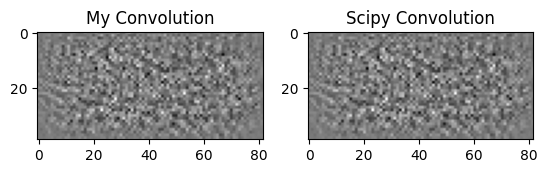

In [29]:
#plot the results
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(my_result, cmap='gray')
plt.title('My Convolution')
plt.subplot(1, 2, 2)
plt.imshow(lib_result, cmap='gray')
plt.title('Scipy Convolution')
plt.show()

Well these were random numbers so it simply looks like noise. Let's check the runtime difference 

In [30]:
image_path = 'image.png'  
image = Image.open(image_path).convert('L')  #convert image to grayscale
image = image.resize((256, 256))  #resize to 256x256 for memory otherwise my kernel crashes
image = np.array(image)

filter_kernel = np.array([[1, 0, -1], 
                          [1, 0, -1], 
                          [1, 0, -1]])  #Random filter: Sobel filter for edge detection

manual_conv_result = new_conv_mul(image, filter_kernel)

scipy_conv_result = signal.convolve2d(image, filter_kernel, mode='full')

print("Manual Convolution Result:\n", manual_conv_result)
print("SciPy Convolve2D Result:\n", scipy_conv_result)

output dimension: 258 258
F 257
 [[ 1.  0.  0. ...  0.  0.  0.]
 [ 0.  1.  0. ...  0.  0.  0.]
 [-1.  0.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -1.  0.  1.]
 [ 0.  0.  0. ...  0. -1.  0.]
 [ 0.  0.  0. ...  0.  0. -1.]]
F 256
 [[ 1.  0.  0. ...  0.  0.  0.]
 [ 0.  1.  0. ...  0.  0.  0.]
 [-1.  0.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -1.  0.  1.]
 [ 0.  0.  0. ...  0. -1.  0.]
 [ 0.  0.  0. ...  0.  0. -1.]]
F 255
 [[ 1.  0.  0. ...  0.  0.  0.]
 [ 0.  1.  0. ...  0.  0.  0.]
 [-1.  0.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -1.  0.  1.]
 [ 0.  0.  0. ...  0. -1.  0.]
 [ 0.  0.  0. ...  0.  0. -1.]]
F 254
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
F 253
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
F 252
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0

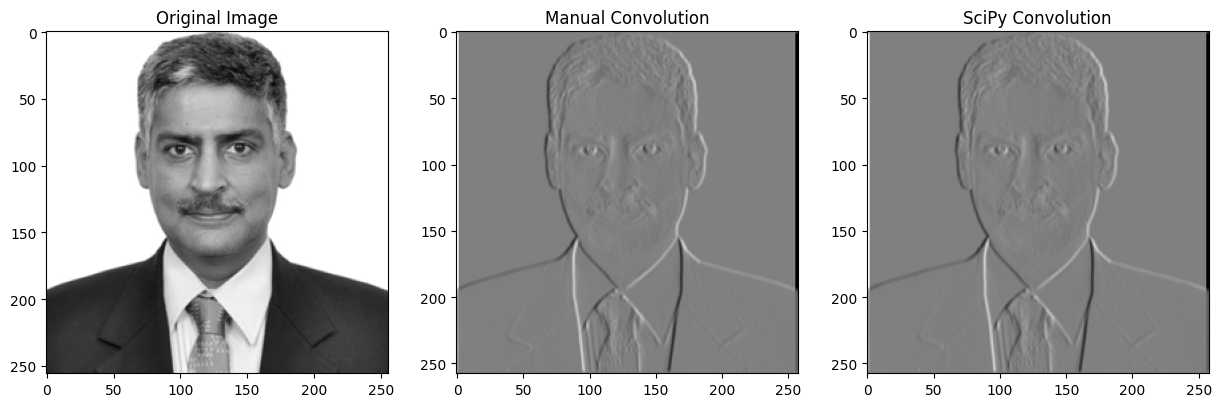

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')

ax[1].imshow(manual_conv_result, cmap='gray')
ax[1].set_title('Manual Convolution')

ax[2].imshow(scipy_conv_result, cmap='gray')
ax[2].set_title('SciPy Convolution')

plt.show()

<h3>Runtime difference </h3>

In [32]:
#large random image and filter
image_large = np.random.rand(200, 200)
filter_large = np.random.rand(40, 40)

#time for scipy's convolve2d
start_time = time.time()
scipy_conv_result = signal.convolve2d(image_large, filter_large, mode='full')
end_time = time.time()
scipy_runtime = end_time - start_time
print(f"SciPy convolve2d runtime: {scipy_runtime:.6f} seconds")

#time for my custom convolution
start_time = time.time()
manual_conv_result = new_conv_mul(image_large, filter_large)
end_time = time.time()
manual_runtime = end_time - start_time
print(f"Manual convolution runtime: {manual_runtime:.6f} seconds")

print(f"Runtime difference: {manual_runtime - scipy_runtime:.6f} seconds")

SciPy convolve2d runtime: 0.155218 seconds
output dimension: 239 239
F 238
 [[0.26671835 0.         0.         ... 0.         0.         0.        ]
 [0.88159928 0.26671835 0.         ... 0.         0.         0.        ]
 [0.2833252  0.88159928 0.26671835 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.79428569 0.94194068 0.75765047]
 [0.         0.         0.         ... 0.         0.79428569 0.94194068]
 [0.         0.         0.         ... 0.         0.         0.79428569]]
F 237
 [[0.44952635 0.         0.         ... 0.         0.         0.        ]
 [0.98551167 0.44952635 0.         ... 0.         0.         0.        ]
 [0.68456503 0.98551167 0.44952635 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.72947599 0.43326782 0.3547745 ]
 [0.         0.         0.         ... 0.         0.72947599 0.43326782]
 [0.         0.         0.         ... 0.         0.         0.72947599]]
F 236
 [[0.34767608 0.       

<h3>Pretty massive time difference. Definitely due to the ineffecient construction of H:= block circulant matrix </h3>

<h1> B3. Using FFT</h1>

<h3>Following the implementation from scipy documentation. I will be implementing gaussian blur using fft, and then I will compare it with my 2D convolution implementation </h3>

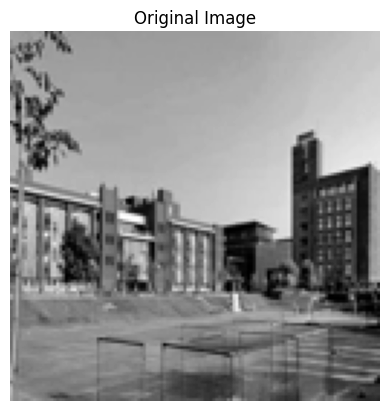

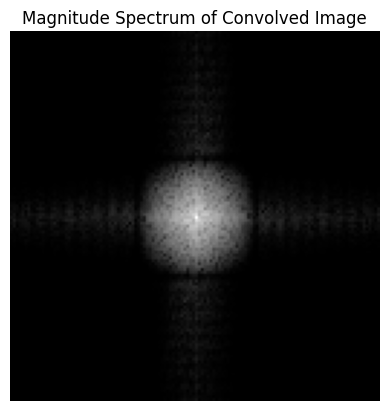

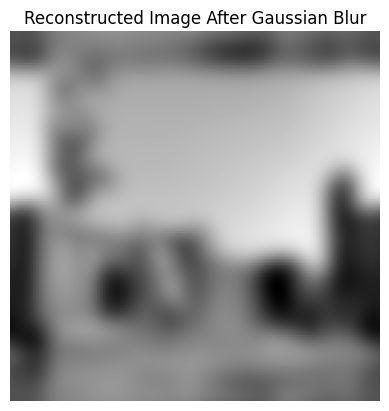

In [33]:
#first processing the image
img = Image.open('ashoka.png').convert('L')  
image_array = np.array(img.resize((128, 128)))

plt.imshow(image_array, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

#then applying fft
image_fft = fft.fft2(image_array)
image_fft_shifted = fft.fftshift(image_fft)  #shift zero frequency to center. this is important because the zero frequency is at the top left corner of the image

#function to create a Gaussian kernel for any size and sigma in the spatial domain. This is implemented from scioy's documentation.
def gaussian_kernel(size, sigma):
    """Generate a 2D Gaussian kernel."""
    x = np.linspace(-size // 2, size // 2, size)
    y = np.linspace(-size // 2, size // 2, size)
    x, y = np.meshgrid(x, y)
    d = np.sqrt(x**2 + y**2)
    gauss = np.exp(-(d**2 / (2.0 * sigma**2)))
    return gauss / np.sum(gauss)

#size and sigma for the Gaussian kernel
kernel_size = 25
sigma = 4

gaussian_kernel = gaussian_kernel(kernel_size, sigma)

start_fft = time.time() #start timer

#Apply FFT to the Gaussian kernel
kernel_fft = fft.fft2(gaussian_kernel, s=image_array.shape)  # FFT of kernel to match the image size
kernel_fft_shifted = fft.fftshift(kernel_fft)  #same shift for the kernel as well

#finally, convolve the image with the Gaussian kernel in the Fourier domain
convolved_fft = image_fft_shifted * kernel_fft_shifted  #which is just multiplication in the Fourier domain


magnitude_spectrum = np.log(np.abs(convolved_fft) + 1)

plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum of Convolved Image')
plt.axis('off')
plt.show()

#Inverse FFT to get back the convolved image in the spatial domain
convolved_fft_ishift = fft.ifftshift(convolved_fft)  #inverse shift
fft_convolved_image = fft.ifft2(convolved_fft_ishift)  #inverse FFT
fft_convolved_image = np.abs(fft_convolved_image) 

end_fft = time.time() #end
fft_runtime = end_fft - start_fft

plt.imshow(fft_convolved_image, cmap='gray')
plt.title('Reconstructed Image After Gaussian Blur')
plt.axis('off')
plt.show()


Let's compare this to the previously defined 2D convolution in B

output dimension: 152 152
F 151
 [[6.11301294e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.37751399e-06 6.11301294e-07 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.90057597e-06 1.37751399e-06 6.11301294e-07 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.33520478e-06
  2.81912416e-06 5.56196239e-06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.33520478e-06 2.81912416e-06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.33520478e-06]]
F 150
 [[1.29068909e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.90845497e-06 1.29068909e-06 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.12421697e-06 2.90845497e-06 1.29068909e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.81912

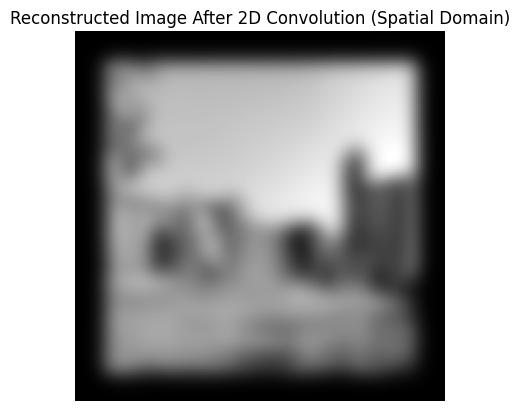

In [34]:
start_manual = time.time()
convolved_image = new_conv_mul(image_array, gaussian_kernel)
end_manual = time.time()
manual_runtime = end_manual - start_manual

plt.imshow(convolved_image, cmap='gray')
plt.title('Reconstructed Image After 2D Convolution (Spatial Domain)')
plt.axis('off')
plt.show()

Runtime and accuracy analysis

In [47]:
# Display runtime comparison
print(f"FFT-based convolution runtime: {fft_runtime:.4f} seconds")
print(f"Manual 2D convolution runtime: {manual_runtime:.4f} seconds")

### Accuracy Analysis
def manual_mse(image1, image2):
    diff = image1 - image2
    squared_diff = np.square(diff)
    mse_value = np.mean(squared_diff)
    return mse_value

#if convolved_image is larger than fft_convolved_image_scipy
convolved_image_resized = convolved_image[:128, :128]

mse_val = manual_mse(fft_convolved_image, convolved_image_resized)
print(f"Mean Squared Error: {mse_val:.6f}")


FFT-based convolution runtime: 0.0511 seconds
Manual 2D convolution runtime: 0.6918 seconds
Mean Squared Error: 1948.242150


<h2> The mse comes from the cropping that occured with my implementation, apart from the edges: the array values are the same</h2>

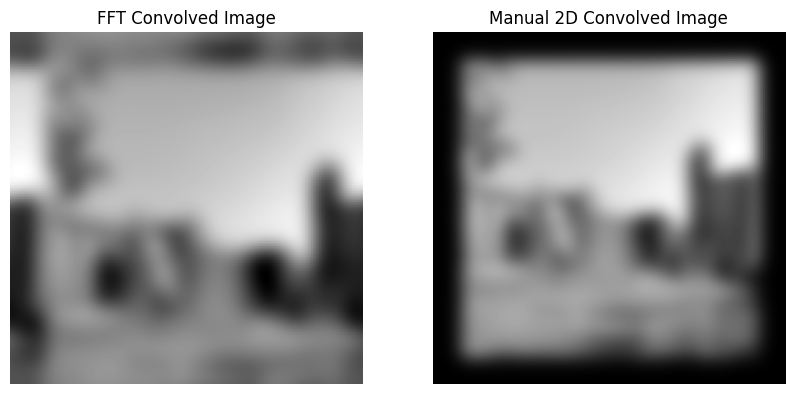

In [48]:
#side-by-side
fig, (ax_fft, ax_manual) = plt.subplots(1, 2, figsize=(10, 5))

ax_fft.imshow(fft_convolved_image, cmap='gray')
ax_fft.set_title('FFT Convolved Image')
ax_fft.axis('off')

ax_manual.imshow(convolved_image, cmap='gray')
ax_manual.set_title('Manual 2D Convolved Image')
ax_manual.axis('off')

plt.show()

I would've liked to use larger images but my laptop probably does not have enough ram

<h4>fft analysis: Why is fft much quicker (apart from the optimisations in the library implementation)? </h4>

<h5> To briefly summarize this: https://www.analog.com/media/en/technical-documentation/dsp-book/dsp_book_ch18.pdf. </h5>
<h6> FFT or DFT in this case uses the overlap-add method to break down the signal into smaller simpler segments. Each og these smaller segments are convolved with the kernel and the output signal is reformed by adding the overlapping parts  </h6>

<h1> </h1>